Figure 5 data analysis
============

In [ ]:
# Only run this code cell if you are not running this notebook from the binder
pkg install -forge io statistics tablicious
pkg install "https://github.com/gnu-octave/statistics-resampling/archive/refs/heads/master.zip"
pkg load io statistics tablicious statistics-resampling

Get info about Octave and it's packages:

In [1]:
ver('Octave');
pkg list;
pkg describe -verbose statistics-resampling

----------------------------------------------------------------------
GNU Octave Version: 8.3.0 (hg id: 6fc591af58ba)
GNU Octave License: GNU General Public License
Operating System: Linux 5.15.0-94-generic #104-Ubuntu SMP Tue Jan 9 15:25:40 UTC 2024 x86_64
----------------------------------------------------------------------
Package Name           | Version | Installation directory
-----------------------+---------+-----------------------
                coder  |   1.9.1 | .../octave/api-v58/packages/coder-1.9.1
              control  |   4.0.0 | .../octave/api-v58/packages/control-4.0.0
       data-smoothing  |   1.3.0 | .../api-v58/packages/data-smoothing-1.3.0
            dataframe  |   1.2.0 | .../octave/api-v58/packages/dataframe-1.2.0
               fileio  |   1.2.2 | .../octave/api-v58/packages/fileio-1.2.2
                   ga  |  0.10.3 | .../share/octave/api-v58/packages/ga-0.10.3
                   io *|   2.6.4 | .../share/octave/api-v58/packages/io-2.6.4
        misce

In [4]:
% Get information about bootlm function which we will use for the analysis
help bootlm

'bootlm' is a function from the file /home/jovyan/.local/share/octave/api-v58/packages/statistics-resampling-5.5.10/bootlm.m

 Uses bootstrap to calculate confidence intervals (and p-values) for the
 regression coefficients from a linear model and performs N-way ANOVA.

 -- Function File: bootlm (Y, X)
 -- Function File: bootlm (Y, GROUP)
 -- Function File: bootlm (Y, GROUP, ..., NAME, VALUE)
 -- Function File: bootlm (Y, GROUP, ..., 'dim', DIM)
 -- Function File: bootlm (Y, GROUP, ..., 'continuous', CONTINUOUS)
 -- Function File: bootlm (Y, GROUP, ..., 'model', MODELTYPE)
 -- Function File: bootlm (Y, GROUP, ..., 'standardize', STANDARDIZE)
 -- Function File: bootlm (Y, GROUP, ..., 'varnames', VARNAMES)
 -- Function File: bootlm (Y, GROUP, ..., 'method', METHOD)
 -- Function File: bootlm (Y, GROUP, ..., 'method', 'bayesian', 'prior', PRIOR)
 -- Function File: bootlm (Y, GROUP, ..., 'alpha', ALPHA)
 -- Function File: bootlm (Y, GROUP, ..., 'display', DISPOPT)
 -- Function File: bootlm 

**Figure 5c** : Comparing accuracy of event classification methods to detect simulated synaptic currents. Bootstrap two-way ANOVA without interaction (Type I) using `bootlm` with data (in long format) loaded from **fig5c.csv**.


MODEL FORMULA (based on Wilkinson's notation):

acc ~ 1 + simulation + classification

MODEL COEFFICIENTS

name                                   coeff       CI_lower    CI_upper    p-val
--------------------------------------------------------------------------------
(Intercept)                            +0.7490     +0.7221     +0.7759     <.001
simulation_1                           +0.05360    +0.02133    +0.08587     .006
simulation_2                           +0.001026   -0.05472    +0.05677     .961
simulation_3                           -0.03761    -0.1139     +0.03873     .248
classification_1                       -0.4312     -0.4919     -0.3705     <.001
classification_2                       -0.1299     -0.1774     -0.08234    <.001
classification_3                       +0.04753    -0.03185    +0.1269      .214

ANOVA SUMMARY with effect of classification averaged over levels of simulation
F(3,9) = 3.25, p = 0.0931 for the model: acc ~ 1 + simulation
F(3,9) = 107.92, p = 

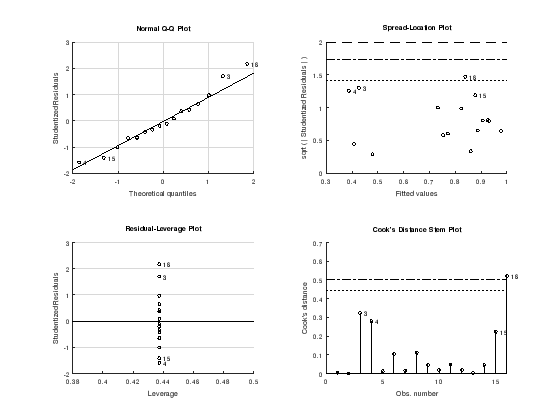

In [19]:
% Load data from comma-separated-value (CSV) file with header
% Formatting: each %d, %s and %f corresponds to an integer, a string and a
% number (double precision) respectively
[sim, class, acc] = textread ('../data/fig5c.csv', '%d %s %f', 'Delimiter', ',', 'HeaderLines', 1);

% Setup orthoganol linear contrasts
% First column : Comparison of no screening (NEG) with the average accuracy of all screening methods (COR, MAN, MLM)
% Second column : Comparison of template screening using Pearsons r of 0.4 (COR) with the average accuracy of machine learning and manual methods (MLM, MAN)
% Third column : Comparison of classification by machine learning (MLM) with manual screening (MAN)
CONTRASTS =  {'effect',
              [ +0.7500000  0.0000000  0.0
                -0.2500000 +0.6666667  0.0
                -0.2500000 -0.3333333 +0.5
                -0.2500000 -0.3333333 -0.5 ]};

% ANOVA using wild bootstrap
% https://gnu-octave.github.io/statistics-resampling/function/bootlm.html#7
[STATS, BOOTSTAT, AOVSTAT] = bootlm (acc, {sim, class}, 'model', 'linear', ...
                             'display', 'on', 'varnames', {'simulation', 'classification'}, ...
                             'contrasts', CONTRASTS, 'seed', 1);

% Report ANOVA results
fprintf ('ANOVA SUMMARY with effect of classification averaged over levels of simulation\n')
for i = 1:numel(AOVSTAT.MODEL)
  fprintf ('F(%u,%u) = %.2f, p = %.3g for the model: %s\n', ...
           AOVSTAT.DF(i), AOVSTAT.DFE, AOVSTAT.F(i), ...
           AOVSTAT.PVAL(i), AOVSTAT.MODEL{i});
end

% Test whether accuracies averaged over levels of simulation differ between the classification methods (using wild bootstrap)
% Confidence intervals are 95% (asymmetric) bootstrap-t intervals
% Type 1 error rate is controlled by Holm-Bonferroni step-wise adjustment
POSTTESTS = bootlm (acc, {sim, class}, 'model', 'linear', 'display', 'on', ...
                                       'varnames', {'simulation', 'classification'}, ...
                                       'contrasts', CONTRASTS, 'dim', 2, ...
                                       'method', 'wild', 'posthoc', 'pairwise', 'alpha', [0.025, 0.975]);

# Calculate estimated marginal means for accuracy of each of the classification methods and their 95% (asymmetric) bootstrap-t confidence intervals 
EMM = bootlm (acc, {sim, class}, 'model', 'linear', 'display', 'on', ...
                                 'varnames', {'simulation', 'classification'}, ...
                                 'contrasts', CONTRASTS, 'dim', 2, ...
                                 'method', 'wild', 'alpha', [0.025, 0.975]);

% Save the figure of the diagnostic plots
print ('../output/fig5c_diagnostic_plots.png','-dpng','-S960,720')

**Figure 5d** : Comparing accuracy of event classification methods to detect simulated synaptic currents that were manually classified as true events. Bootstrap two-way ANOVA without interaction (Type I) using `bootlm` with data (in long format) loaded from **fig5d.csv**.


MODEL FORMULA (based on Wilkinson's notation):

acc ~ 1 + simulation + classification

MODEL COEFFICIENTS

name                                   coeff       CI_lower    CI_upper    p-val
--------------------------------------------------------------------------------
(Intercept)                            +0.4529     +0.4242     +0.4815     <.001
simulation_1                           +0.04560    +0.03046    +0.06074     .003
simulation_2                           +0.02150    -0.1389     +0.1819      .611
simulation_3                           -0.05964    -0.1695     +0.05017     .373
classification_1                       +0.3089     +0.2545     +0.3633     <.001
classification_2                       +0.4367     +0.3395     +0.5339     <.001

ANOVA SUMMARY with effect of classification averaged over levels of simulation
F(3,6) = 1.98, p = 0.255 for the model: acc ~ 1 + simulation
F(2,6) = 65.77, p = 0.0001 for the model: acc ~ 1 + simulation + classification

MODEL FORMULA (based o

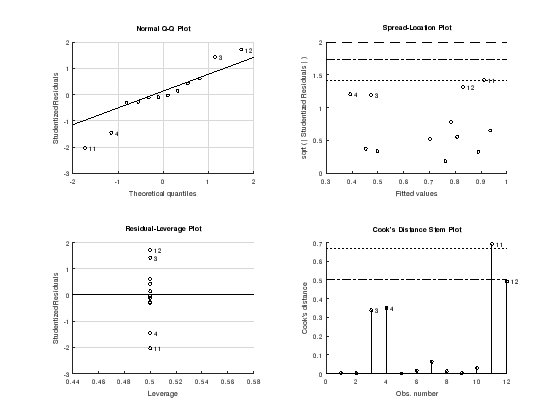

In [20]:
% Load data from comma-separated-value (CSV) file with header
% Formatting: each %d, %s and %f corresponds to an integer, a string and a
% number (double precision) respectively
[sim, class, acc] = textread ('../data/fig5d.csv', '%d %s %f', 'Delimiter', ',', 'HeaderLines', 1);

% Setup orthoganol linear contrasts
% First column : Comparison of no screening (NEG) with the average accuracy of both other methods (COR, MLM)
% Second column : Comparison of template screening using Pearsons r of 0.4 (COR) with classification by machine learning (MLM)
CONTRASTS =  {'effect',
              [ -0.6666667  0.0
                +0.3333333 -0.5
                +0.3333333 +0.5 ]};

% ANOVA using wild bootstrap
% https://gnu-octave.github.io/statistics-resampling/function/bootlm.html#7
[STATS, BOOTSTAT, AOVSTAT] = bootlm (acc, {sim, class}, 'model', ...
                             'linear', 'display', 'on', 'varnames', ...
                             {'simulation', 'classification'}, 'seed', 1);

% Report ANOVA results
fprintf ('ANOVA SUMMARY with effect of classification averaged over levels of simulation\n')
for i = 1:numel(AOVSTAT.MODEL)
  fprintf ('F(%u,%u) = %.2f, p = %.3g for the model: %s\n', ...
           AOVSTAT.DF(i), AOVSTAT.DFE, AOVSTAT.F(i), ...
           AOVSTAT.PVAL(i), AOVSTAT.MODEL{i});
end

% Test whether accuracies averaged over levels of simulation differ between the classification methods (using wild bootstrap)
% Confidence intervals are 95% (asymmetric) bootstrap-t intervals
% Type 1 error rate is controlled by Holm-Bonferroni step-wise adjustment
POSTTESTS = bootlm (acc, {sim, class}, 'model', ...
                          'linear', 'display', 'on', 'varnames', ...
                          {'simulation', 'classification'}, 'dim', 2, ...
                          'method', 'wild', 'posthoc', 'pairwise', 'alpha', [0.025, 0.975]);

# Calculate estimated marginal means for accuracy of each of the classification methods and their 95% (asymmetric) bootstrap-t confidence intervals 
EMM = bootlm (acc, {sim, class}, 'model', ...
                                 'linear', 'display', 'on', 'varnames', ...
                                 {'simulation', 'classification'}, 'dim', 2, ...
                                 'method', 'wild', 'alpha', [0.025, 0.975]);

% Save the figure of the diagnostic plots
print ('../output/fig5d_diagnostic_plots.png','-dpng','-S960,720')

**Figure 5e** : Comparing false discovery rate (FDR) of event classification methods to detect simulated synaptic currents that were manually classified as true events. Bootstrap two-way ANOVA without interaction (Type I) using `bootlm` with data (in long format) loaded from **fig5e.csv**.


MODEL FORMULA (based on Wilkinson's notation):

acc ~ 1 + simulation + classification

MODEL COEFFICIENTS

name                                   coeff       CI_lower    CI_upper    p-val
--------------------------------------------------------------------------------
(Intercept)                            +0.5337     +0.5095     +0.5578     <.001
simulation_1                           -0.03325    -0.06501    -0.001487    .042
simulation_2                           -0.04129    -0.1524     +0.06979     .298
simulation_3                           +0.1210     +0.04572    +0.1962      .004
classification_1                       -0.2127     -0.2547     -0.1708     <.001
classification_2                       -0.5133     -0.5852     -0.4414     <.001

ANOVA SUMMARY with effect of classification averaged over levels of simulation
F(3,6) = 11.77, p = 0.00366 for the model: acc ~ 1 + simulation
F(2,6) = 185.21, p = 0.0001 for the model: acc ~ 1 + simulation + classification

MODEL FORMULA (bas

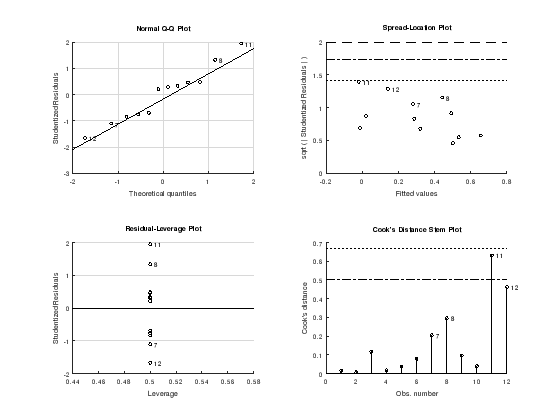

In [21]:
% Load data from comma-separated-value (CSV) file with header
% Formatting: each %d, %s and %f corresponds to an integer, a string and a
% number (double precision) respectively
[sim, class, acc] = textread ('../data/fig5e.csv', '%d %s %f', 'Delimiter', ',', 'HeaderLines', 1);

% Setup orthoganol linear contrasts
% First column : Comparison of no screening (NEG) with the average FDR of both other methods (COR, MLM)
% Second column : Comparison of template screening using Pearsons r of 0.4 (COR) with classification by machine learning (MLM)
CONTRASTS =  {'effect',
              [ -0.6666667  0.0
                +0.3333333 -0.5
                +0.3333333 +0.5 ]};

% ANOVA using wild bootstrap
% https://gnu-octave.github.io/statistics-resampling/function/bootlm.html#7
[STATS, BOOTSTAT, AOVSTAT] = bootlm (acc, {sim, class}, 'model', ...
                             'linear', 'display', 'on', 'varnames', ...
                             {'simulation', 'classification'}, 'seed', 1);

% Report ANOVA results
fprintf ('ANOVA SUMMARY with effect of classification averaged over levels of simulation\n')
for i = 1:numel(AOVSTAT.MODEL)
  fprintf ('F(%u,%u) = %.2f, p = %.3g for the model: %s\n', ...
           AOVSTAT.DF(i), AOVSTAT.DFE, AOVSTAT.F(i), ...
           AOVSTAT.PVAL(i), AOVSTAT.MODEL{i});
end

% Test whether FDR averaged over levels of simulation differ between the classification methods (using wild bootstrap)
% Confidence intervals are 95% (asymmetric) bootstrap-t intervals
% Type 1 error rate is controlled by Holm-Bonferroni step-wise adjustment
POSTTESTS = bootlm (acc, {sim, class}, 'model', ...
                          'linear', 'display', 'on', 'varnames', ...
                          {'simulation', 'classification'}, 'dim', 2, ...
                          'method', 'wild', 'posthoc', 'pairwise', 'alpha', [0.025, 0.975]);

# Calculate estimated marginal means for FDR of each of the classification methods and their 95% (asymmetric) bootstrap-t confidence intervals 
EMM = bootlm (acc, {sim, class}, 'model', ...
                                 'linear', 'display', 'on', 'varnames', ...
                                 {'simulation', 'classification'}, 'dim', 2, ...
                                 'method', 'wild', 'alpha', [0.025, 0.975]);

% Save the figure of the diagnostic plots
print ('../output/fig5e_diagnostic_plots.png','-dpng','-S960,720')